The purpose of this Jupyter notebook is to visualize Boston's geographic data. The figures generated here correspond to Figures 2 and 3 in the paper. Figure 2 shows Boston's bikeshare stations and nearby public transit stops. Figure 3 displays the average daily bikeshare ridership (left), per capita income (middle), and number of jobs (right) within Boston's census tracts.   

First we import the Python libraries that we need.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

Read in census data needed for parts of Figure 3.

In [2]:
df_census = pd.read_csv('../Data/acs2015_census_tract_data.csv')
df_wac = pd.read_csv('../Data/ma_employment_data.csv')

Read in Massachusetts' shape file and extract out the Boston area.
Since `CENSUS2010TRACTS_POLY.shp` is a very large file, you need to manually download the `census2010_tracts_MA` folder and place it into the `Geography Data` folder from [here](http://download.massgis.digital.mass.gov/shapefiles/census2010/CENSUS2010_BLK_BG_TRCT_SHP.zip).   

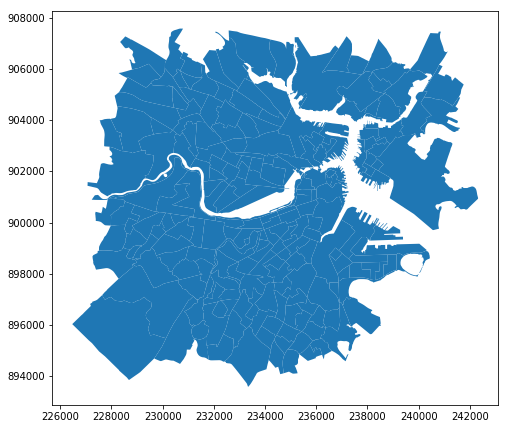

In [3]:
ma_map = gpd.read_file('../Data/Geography Data/census2010_tracts_MA/CENSUS2010TRACTS_POLY.shp')
df_data = pd.read_csv('../Data/boston_summer_bike_station_data.csv')

# Get max and min lat and long and use as thresholds
relevant_lats = set()
relevant_longs = set()
for index, row in ma_map.iterrows():
    if int(row['GEOID10']) in df_data['census_tract'].values:
        relevant_lats.add(float(row['INTPTLAT10']))
        relevant_longs.add(float(row['INTPTLON10']))
        
max_lat = max(relevant_lats)
min_lat = min(relevant_lats)

max_long = max(relevant_longs)
min_long = min(relevant_longs)

boston_map_df = pd.DataFrame(columns=ma_map.columns)
for index, row in ma_map.iterrows():
    temp_lat = float(row['INTPTLAT10'])
    temp_long = float(row['INTPTLON10'])
    if temp_lat <= max_lat and temp_lat >= min_lat and temp_long <= max_long and temp_long >= min_long:
        boston_map_df = boston_map_df.append(row, ignore_index=False)
        
boston_map = gpd.GeoDataFrame(boston_map_df)

fig,ax = plt.subplots(figsize=(8, 8))
boston_map.plot(ax=ax)

Create the left side of Figure 3:
- average bike ridership across census tracts and then merge with `boston_map`
- plot average bike ridership

In [4]:
grouped_tract = df_data.groupby('census_tract')
df_data['average_average_ridership'] = np.nan
df_sub = pd.DataFrame(columns=df_data.columns)
for tract, df_tract in grouped_tract:
    average_average_ridership = sum(df_tract['average_ridership'].values)/(df_tract.shape[0])
    first_row = df_tract.head(1)
    first_row['average_average_ridership'] = average_average_ridership
    df_sub = df_sub.append(first_row, ignore_index=True)
    
df_sub=df_sub.rename(columns = {'census_tract':'GEOID10'})

boston_map_df['GEOID10'] = pd.to_numeric(boston_map_df['GEOID10'])
boston_map_df_new = boston_map_df.merge(df_sub, on='GEOID10', how='left', suffixes=('False', 'False'))

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


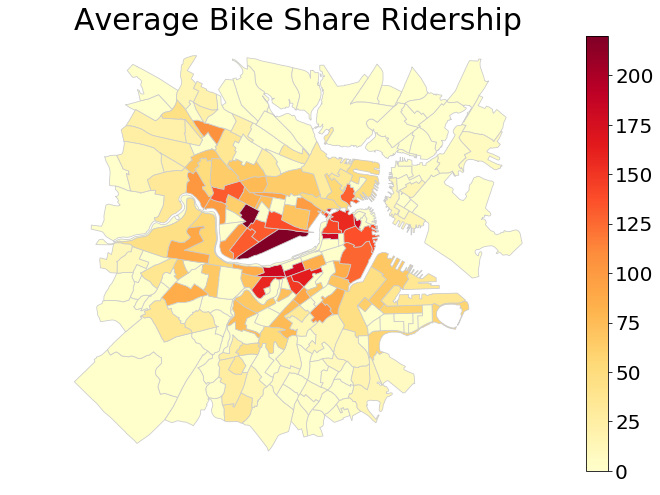

In [5]:
boston_map_df_new['average_average_ridership'] = boston_map_df_new['average_average_ridership'].fillna(0)

boston_map_new = gpd.GeoDataFrame(boston_map_df_new)
variable = 'average_average_ridership'
vmin, vmax = 0, 220
fig, ax = plt.subplots(1, figsize=(15, 8))
boston_map_new.plot(column=variable, cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.set_title('Average Bike Share Ridership', fontdict={'fontsize': '30', 'fontweight' : '3'})
ax.axis('off')

# Create color bar
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

Create the middle of Figure 3:
- find the missing income per capita values for census tracts surrounding Boston
- plot income per capita

In [6]:
for index, row in boston_map_df_new.iterrows():
    if pd.isna(row['income_per_cap']):
        tract = row['GEOID10']
        temp_income = df_census[df_census['CensusTract']==tract].head(1)['IncomePerCap'].values[0]
        boston_map_df_new.loc[index, 'income_per_cap'] = temp_income

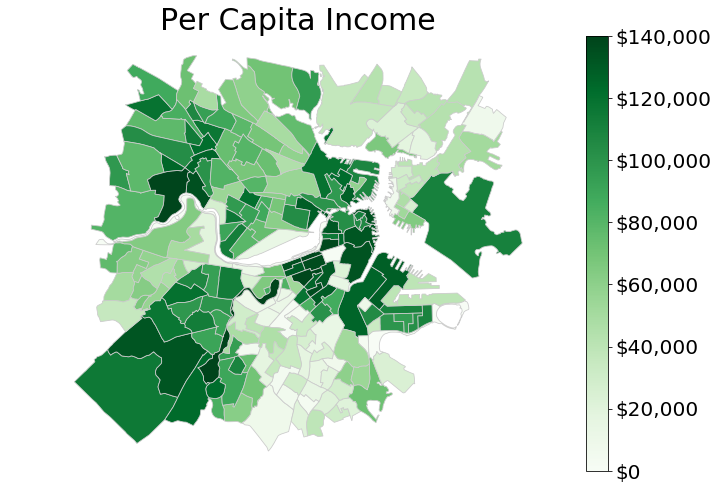

In [7]:
import matplotlib.ticker as mtick
boston_map_new = gpd.GeoDataFrame(boston_map_df_new)
variable = 'income_per_cap'
vmin, vmax = 0, 140000
fig, ax = plt.subplots(1, figsize=(15, 8))
boston_map_new.plot(column=variable, cmap='Greens', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.set_title('Per Capita Income', fontdict={'fontsize': '30', 'fontweight' : '3'})
ax.axis('off')

# Create color bar
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
cbar.ax.yaxis.set_major_formatter(tick) 
cbar.ax.tick_params(labelsize=20)

Create the right side of Figure 3:
- for every row in `boston_map_df_new` with a NaN in `total_num_jobs`, find the population from `df_wac`
- plot number of jobs

In [8]:
for index, row in boston_map_df_new.iterrows():
    if pd.isna(row['total_num_jobs']):
        tract = row['GEOID10']
        try:
            temp_num_job = df_wac[df_wac['CensusTract']==tract].head(1)['C000'].values[0]
            boston_map_df_new.loc[index, 'total_num_jobs'] = temp_num_job
        except:
            continue

C:\ProgramData\Miniconda3\lib\site-packages\geopandas\plotting.py:524: RuntimeWarning: invalid value encountered in less
  categories.sort()


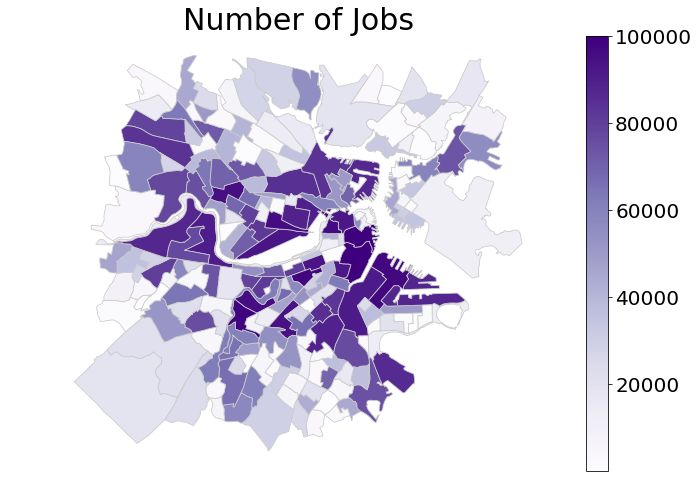

In [9]:
boston_map_new = gpd.GeoDataFrame(boston_map_df_new)
variable = 'total_num_jobs'
vmin, vmax = 1, 100000
fig, ax = plt.subplots(1, figsize=(15, 8))
boston_map_new.plot(column=variable, cmap='Purples', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.set_title('Number of Jobs', fontdict={'fontsize': '30', 'fontweight' : '3'})
ax.axis('off')

# Create color bar
sm = plt.cm.ScalarMappable(cmap='Purples', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

Create Figure 2:
- map out bike stations and public transit stops
- the color of bike station dots correspond to average bike ridership and the color of public transit stops correspond to transit type

Text(0, 0.5, 'Average Bike Ridership')

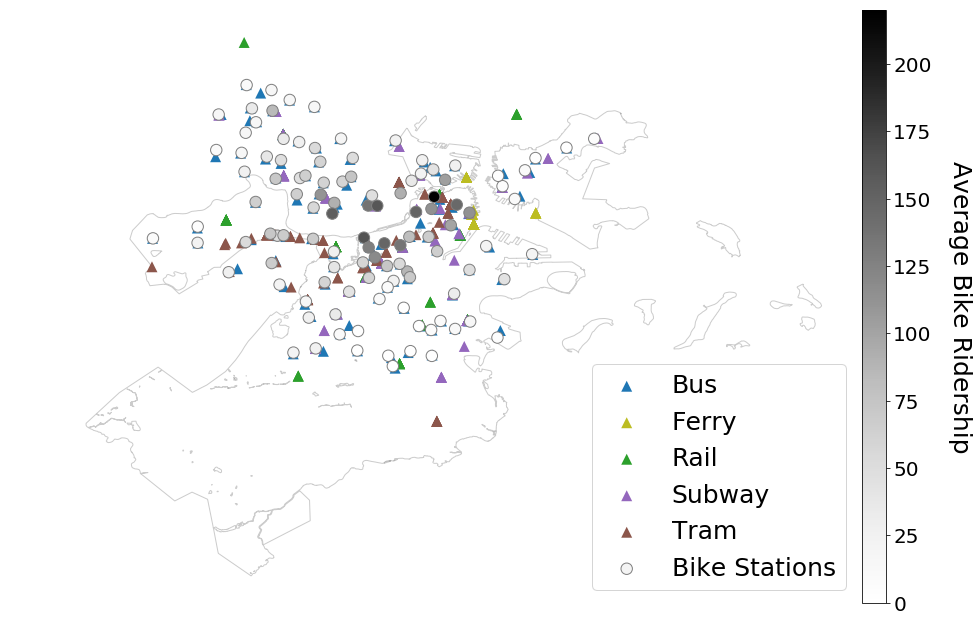

In [10]:
geometry = []
crs = {'init':'epsg:4269'} # coordinate reference system
# crs = {'proj': 'lcc', 'lat_1': 41.71666666666667, 'lat_2': 42.68333333333333, 'lat_0': 41, 'lon_0': -71.5, 'x_0': 200000, 'y_0': 750000, 'datum': 'NAD83', 'units': 'm', 'no_defs': True}
df_points = pd.DataFrame(columns=['type', 'longitude', 'latitude', 'average_ridership'])

boston_map_df_new2 = boston_map_df_new.dropna()

for index, row in boston_map_df_new2.iterrows():
    df_points = df_points.append({'type':'bike', 'longitude':row['station_long'],
                                 'latitude':row['station_lat'], 'average_ridership':row['average_ridership']}, ignore_index=True)
    geometry.append(Point(row['station_long'],row['station_lat']))
    
transit_types = ['bus', 'ferry', 'rail', 'subway', 'tram']

for transit_type in transit_types:
    for index, row in boston_map_df_new2.iterrows():
        df_points = df_points.append({'type':transit_type, 'longitude':row[transit_type+'_long'],
                                      'latitude':row[transit_type+'_lat'], 'average_ridership':np.nan}, ignore_index=True)
        geometry.append(Point(row[transit_type+'_long'],row[transit_type+'_lat'])) 
        
geo_df_points = gpd.GeoDataFrame(df_points, crs = crs, geometry=geometry)

boston_map2 = gpd.read_file('../Data/Geography Data/City_of_Boston_Boundary.shp')
fig,ax = plt.subplots(figsize=(15, 16))
boston_map2.plot(ax=ax, alpha=0.4, color='white', linewidth=1, edgecolor='grey') #light grey = #B8B8B8

colors = ['tab:blue', 'tab:olive', 'tab:green', 'tab:purple', 'tab:brown']
for i, transit_type in enumerate(transit_types):
    geo_df_points[geo_df_points['type']==transit_type].plot(ax=ax, alpha=1, edgecolor='none', markersize=120, color=colors[i], 
                                           marker = '^', label=transit_type.capitalize())

    
geo_df_points[geo_df_points['type']=='bike'].plot(ax=ax, alpha=1, markersize=130, column='average_ridership', 
                                       marker = 'o', edgecolor='grey', label='Bike Stations', cmap='Greys')

# ax.set_title('Bike Stations and Nearby Public Transit Stops', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.axis('off')
plt.legend(prop={'size': 25})

# Create color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
sm = plt.cm.ScalarMappable(cmap='Greys', norm=plt.Normalize(vmin=0, vmax=220))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.ax.get_yaxis().labelpad = 40
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel('Average Bike Ridership', rotation=270, size=25)